In [49]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.linear_model as sklm
import pywt
import scipy

from scipy.fftpack import fft, fftfreq, ifft

### Inversion principle of WRIM
The original LORENTZ A1 is decomposed into coarse and fine two sub-spaces. The signal
parts corresponding to the fine and coarse sub-spaces are A2, D2, respectively. A2 corresponds to the approximation part, namely, overall trend of ACF. D2 corresponds to the detail part, namely, removed noise form original LORENTZ. Then, the approximation part A2 continues to be decomposed into A3 and D3. Thus, the detail part is gradually removed from LORENTZ. This process continues repeatedly until the decomposition scale reaches the coarsest scale. With the increase of decomposition scale, LORENTZ noise of the coarser space is gradually removed, and then LORENTZ of this space becomes relatively smoother. LORENTZ can be  written as 

$ LORENTZ(A_1) = A_2 + D_2 = A_3 + D_3 + D_2 = A_4 + D_4 + D_3 + D_2 $  

Through the multi-scale decomposition, the original LORENTZ is composed into the approximation parts A2, A3, and A4 in the different sub-spaces. Correspondingly, the original inversion problem is divided into many sub-problems.  
$ A_ix_i = b, i = 1, 2, 3, 4 $  
in which $ A_i, x_i $ are calculated in the diameter inversion range [dmin, dmax] of the different sub-spaces.

![alt-текст](https://pp.userapi.com/c852320/v852320326/6e7e3/dEdhPGSU20Q.jpg "Необязательный титул")

In [2]:
class Simulator:
    
    kb = 1.308064e-23 # Boltzmann constant
    
    def __init__(self):
        pass


    def configure_experiment(self, 
                             lambda_lazer = 650e-9,
                             temperature = 273.15,
                             theta = np.pi / 3,
                             n = 1.33,
                             eta = 0.958e-3):
        
        self.lambda_lazer = lambda_lazer
        self.temperature = temperature
        self.theta = theta
        self.n = n
        self.eta = eta
        
        #Evaluate coefficient
        self.coeff = 2*(Simulator.kb * self.temperature/(3 * np.pi * self.eta)) * (4 * np.pi * self.n / self.lambda_lazer)**2 * np.sin(self.theta / 2)**2
    
    
    def get_lorentz(self, diameter, freq):
        if diameter == 0:
            raise ValueError('zero passed as a diameter')
        
        G = self.coeff / diameter
        
        return 1 / np.pi * G / ((2 * np.pi * freq)**2 + G**2)

# Ideal Lorentz Generation

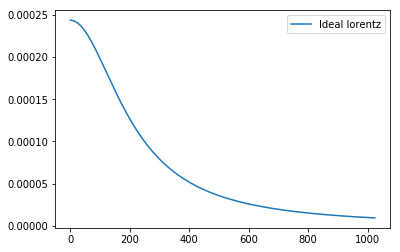

In [3]:
%matplotlib inline

simulator = Simulator()
simulator.configure_experiment()

N_f = 2**12
f_max = 2**10

freqs = np.linspace(0, f_max, N_f)
ideal_lorentz = simulator.get_lorentz(100e-9, freqs)

fig, ax = plt.subplots()
ax.plot(freqs, ideal_lorentz, label='Ideal lorentz')
plt.legend()

# Experimental Lorentz Generation

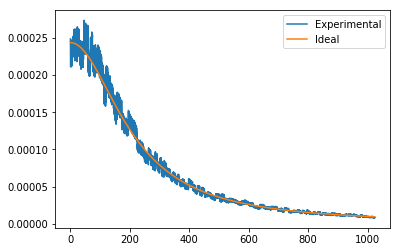

In [5]:
noise_level = 0.09
deviation_noise_level = 0.09

deviation_interval_size = 30
num_deviation_intervals = int(len(ideal_lorentz) / deviation_interval_size) + 1
deviation_noise_levels = np.random.uniform(-deviation_noise_level, deviation_noise_level, num_deviation_intervals)

exp_lorentz_values = []

for i in range(len(ideal_lorentz)):
    value = ideal_lorentz[i]
    
    deviation_interval_index = int(i / deviation_interval_size)
    value *= (1 + deviation_noise_levels[deviation_interval_index])
    
    value *= (1 + np.random.uniform(-noise_level, noise_level))
    
    exp_lorentz_values.append(value)

exp_lorentz = np.array(exp_lorentz_values)

fig, ax = plt.subplots()
ax.plot(freqs, exp_lorentz, label='Experimental')
ax.plot(freqs, ideal_lorentz, label='Ideal')
plt.legend()

# WRIM 

In [ ]:
coeff = simulator.coeff

# initial diameters
d_min = 1e-9 # 1 нм
d_max = 2000e-9

# create net
G_min = coeff/d_max
G_max = coeff/d_min
N = 256*8
M = len(freqs)
p = (G_max/G_min)**(1/(N-1))
G = np.zeros(N)

# uniform net
for j in range(N):
    G[j] = G_min * (p**j)

A = np.zeros((M,N))

# Maxtrix of coefficients
for i in range(M):
    for j in range(N):
        A[i,j] = G[j] / ((2 * np.pi * freqs[i])**2 + G[j]**2)
        
clf = sklm.Ridge(alpha = 5e-7)
clf.fit(A, result_lorentz)
a1 = clf.coef_

clf = sklm.Ridge(alpha = 5e-7)
clf.fit(A, ideal_lorentz)
a2 = clf.coef_

fig = plt.figure()
ax = plt.subplot(3,1,1)
line, = plt.plot(1e+9 * coeff/G, a1,'.-', color='green', markersize=1,label='Experiment')
line, = plt.plot(1e+9 * coeff/G, a2,'.-', color='orange', markersize=1, label='Ideal')
ax.set_xscale('log')
plt.xlim(1, 2000)

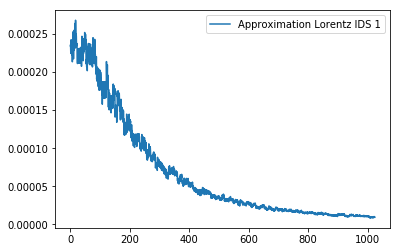

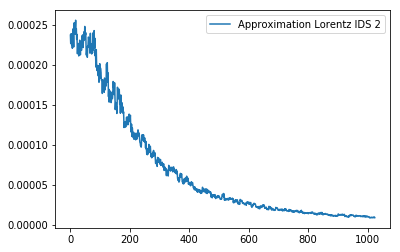

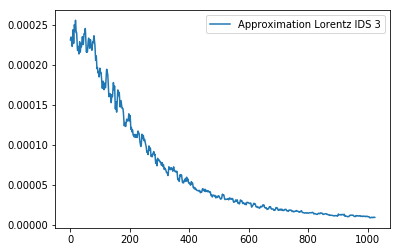

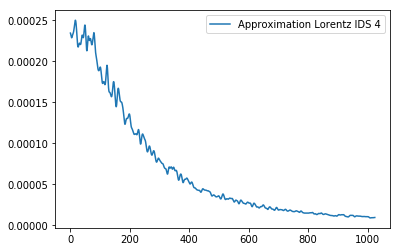

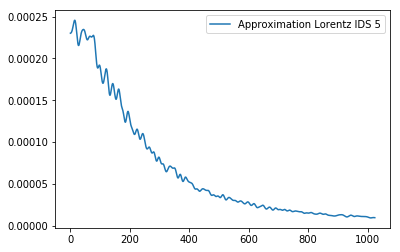

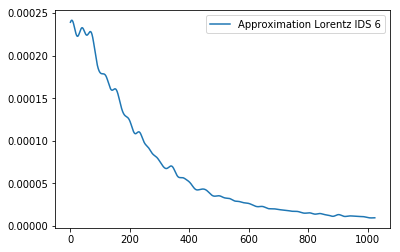

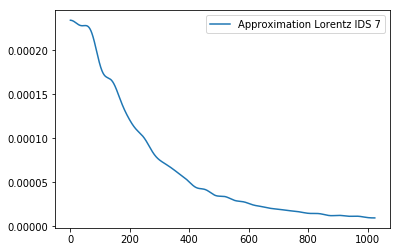

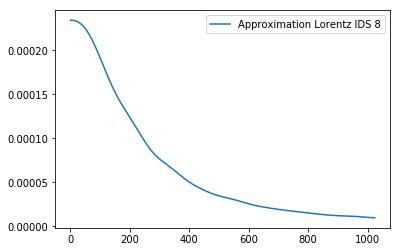

In [9]:
for i in range(1, 9):
    approximation_lorentz = get_decomposition(exp_lorentz, level=i)
    
    fig, ax = plt.subplots()
    ax.plot(freqs, approximation_lorentz, label=f'Approximation Lorentz IDS {i}')
    plt.legend()

# Main Study 

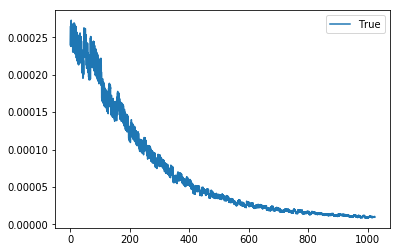

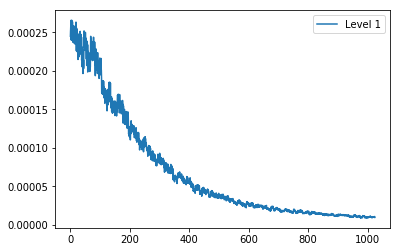

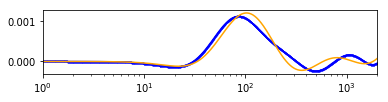

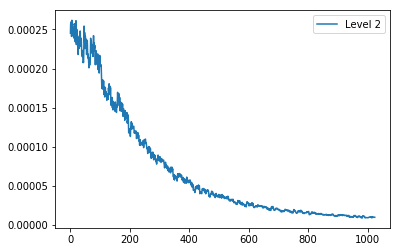

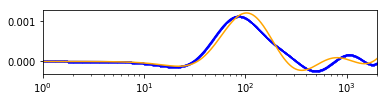

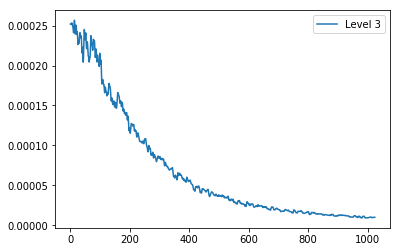

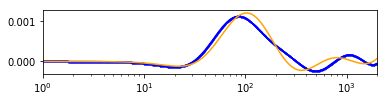

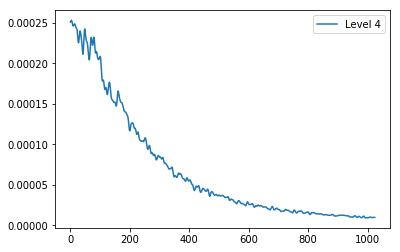

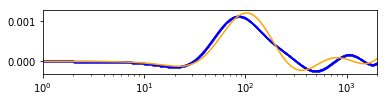

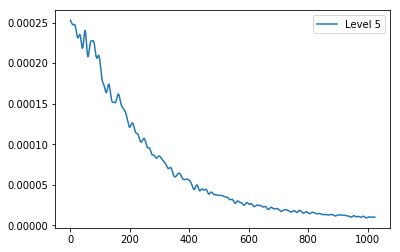

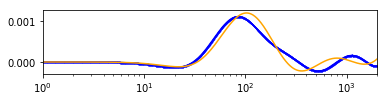

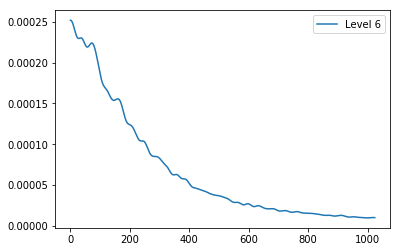

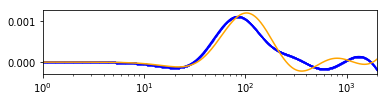

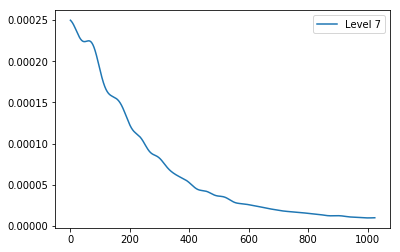

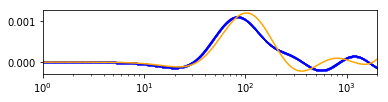

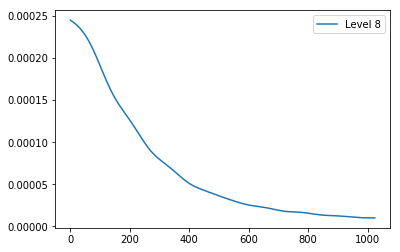

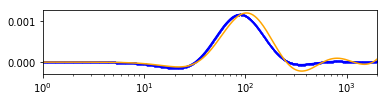

In [21]:
from functools import reduce

y = exp_lorentz

fig, ax = plt.subplots()
ax.plot(freqs, y, label='True')
plt.legend()

lorentz = exp_lorentz

for i in range(1, 9):
    CA = pywt.downcoef('a', exp_lorentz, wavelet='db25', level=i)
    approx = pywt.upcoef('a', CA, wavelet='db25', level=i, take=len(exp_lorentz))
    
    fig, ax = plt.subplots()
    ax.plot(freqs, approx, label=f'Level {i}')
    plt.legend()
    
    coeff = simulator.coeff

    # Initial interval
    d_min = 1e-9 # 1 нм
    d_max = 2000e-9

    G_min = coeff/d_max
    G_max = coeff/d_min
    N = 256*8
    M = len(freqs)
    p = (G_max/G_min)**(1/(N-1))
    G = np.zeros(N)
т
    for j in range(N):
        G[j] = G_min * (p**j)

    A = np.zeros((M,N))


    for i in range(M):
        for j in range(N):
            A[i,j] = G[j] / ((2 * np.pi * freqs[i])**2 + G[j]**2)
            
    clf = sklm.Ridge(alpha = 5e-5)
    clf.fit(A, approx)
    a1 = clf.coef_
    
    clf.fit(A, ideal_lorentz)
    a2 = clf.coef_
    
    
    fig1 = plt.figure()
    ax1 = plt.subplot(3, 1, 1)
    line,  = plt.plot(1e+9 * coeff/G, a1,'.-', markersize=1, color='blue')
    line_, = plt.plot(1e+9 * coeff/G, a2, markersize=1, color='orange')
    ax1.set_xscale('log')
    plt.xlim(1, 2000)
    

# Two peaks

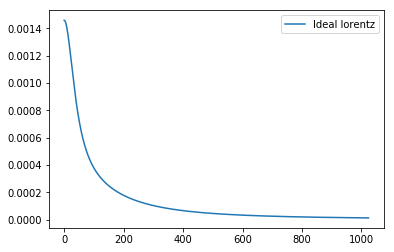

In [22]:
%matplotlib inline

simulator = Simulator()
simulator.configure_experiment()

N_f = 2**12
f_max = 2**10

freqs = np.linspace(0, f_max, N_f)
ideal_lorentz = simulator.get_lorentz(100e-9, freqs) + simulator.get_lorentz(500e-9, freqs) # 100nm and 500nm

fig, ax = plt.subplots()
ax.plot(freqs, ideal_lorentz, label='Ideal lorentz')
plt.legend()

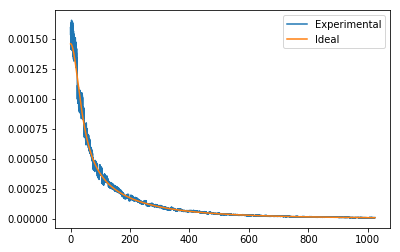

In [23]:
noise_level = 0.09
deviation_noise_level = 0.09

deviation_interval_size = 30
num_deviation_intervals = int(len(ideal_lorentz) / deviation_interval_size) + 1
deviation_noise_levels = np.random.uniform(-deviation_noise_level, deviation_noise_level, num_deviation_intervals)

exp_lorentz_values = []

for i in range(len(ideal_lorentz)):
    value = ideal_lorentz[i]
    
    deviation_interval_index = int(i / deviation_interval_size)
    value *= (1 + deviation_noise_levels[deviation_interval_index])
    
    value *= (1 + np.random.uniform(-noise_level, noise_level))
    
    exp_lorentz_values.append(value)

exp_lorentz = np.array(exp_lorentz_values)

#exp_lorentz = np.array(list(map(lambda x: x * (1 + np.random.uniform(-noise_level, noise_level)), ideal_lorentz)))

fig, ax = plt.subplots()
ax.plot(freqs, exp_lorentz, label='Experimental')
ax.plot(freqs, ideal_lorentz, label='Ideal')
plt.legend()

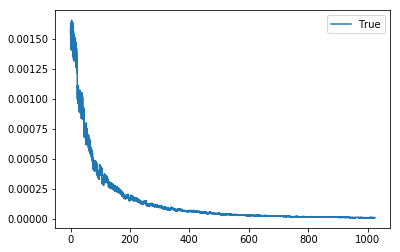

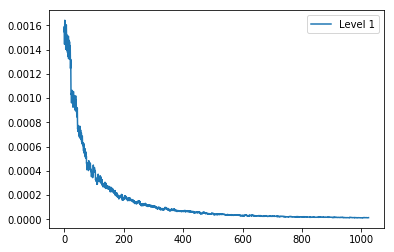

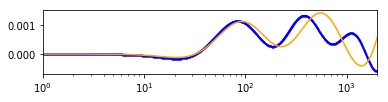

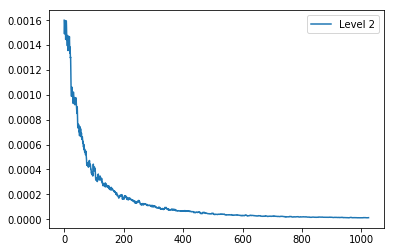

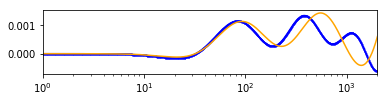

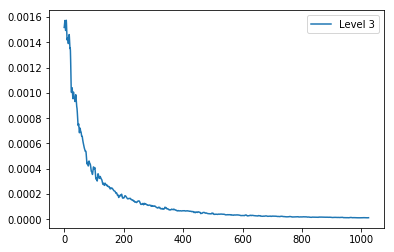

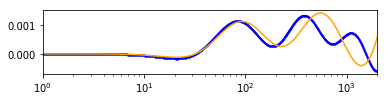

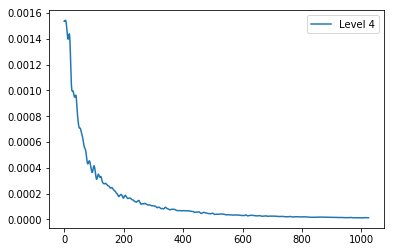

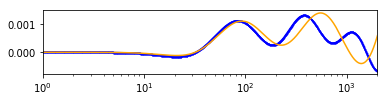

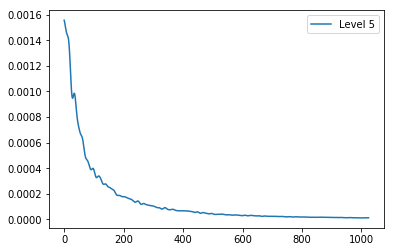

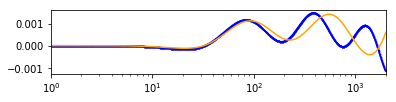

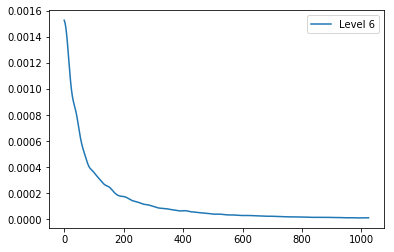

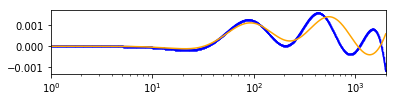

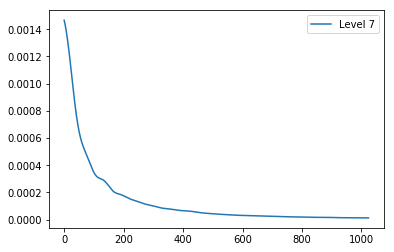

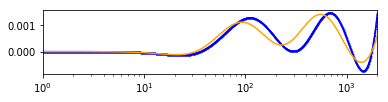

In [25]:
from functools import reduce

y = exp_lorentz

fig, ax = plt.subplots()
ax.plot(freqs, y, label='True')
plt.legend()

lorentz = exp_lorentz

for i in range(1, 8):
    CA = pywt.downcoef('a', exp_lorentz, wavelet='db25', level=i)
    approx = pywt.upcoef('a', CA, wavelet='db25', level=i, take=len(exp_lorentz))
    
    fig, ax = plt.subplots()
    ax.plot(freqs, approx, label=f'Level {i}')
    plt.legend()
    
    coeff = simulator.coeff

    # Initial interval
    d_min = 1e-9 # 1 нм
    d_max = 2000e-9

    G_min = coeff/d_max
    G_max = coeff/d_min
    N = 256*8
    M = len(freqs)
    p = (G_max/G_min)**(1/(N-1))
    G = np.zeros(N)

    for j in range(N):
        G[j] = G_min * (p**j)

    A = np.zeros((M,N))

    # Matrix of coefficients
    for i in range(M):
        for j in range(N):
            A[i,j] = G[j] / ((2 * np.pi * freqs[i])**2 + G[j]**2)
            
    clf = sklm.Ridge(alpha = 5e-5)
    clf.fit(A, approx)
    a1 = clf.coef_
    
    clf.fit(A, ideal_lorentz)
    a2 = clf.coef_
    
    
    fig1 = plt.figure()
    ax1 = plt.subplot(3, 1, 1)
    line,  = plt.plot(1e+9 * coeff/G, a1,'.-', markersize=1, color='blue')
    line_, = plt.plot(1e+9 * coeff/G, a2, markersize=1, color='orange')
    ax1.set_xscale('log')
    plt.xlim(1, 2000)

# Effect of Lorentz noise on Optimal IDS

We use deviation-noise model here, because it can be harnessed better in order to obtain key results of the paper

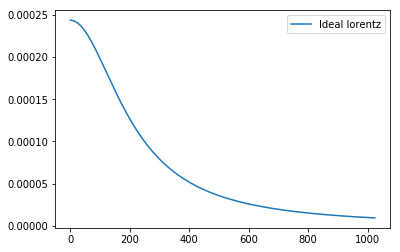

In [38]:
%matplotlib inline

simulator = Simulator()
simulator.configure_experiment()

N_f = 2**12
f_max = 2**10

freqs = np.linspace(0, f_max, N_f)
ideal_lorentz = simulator.get_lorentz(100e-9, freqs) # 100 nm

fig, ax = plt.subplots()
ax.plot(freqs, ideal_lorentz, label='Ideal lorentz')
plt.legend()

In [39]:
#Noise level 0.09
noise_level = 0.09 # main noise level
deviation_noise_level = 0.09 # deviation noise level

deviation_interval_size = 30 # size of each deviation interval
num_deviation_intervals = int(len(ideal_lorentz) / deviation_interval_size) + 1
deviation_noise_levels = np.random.uniform(-deviation_noise_level, deviation_noise_level, num_deviation_intervals)

exp_lorentz_values = []

for i in range(len(ideal_lorentz)):
    value = ideal_lorentz[i]
    
    deviation_interval_index = int(i / deviation_interval_size)
    value *= (1 + deviation_noise_levels[deviation_interval_index])
    
    value *= (1 + np.random.uniform(-noise_level, noise_level))
    
    exp_lorentz_values.append(value)

exp_lorentz_009 = np.array(exp_lorentz_values)


#Noise level 0.05
noise_level = 0.05
deviation_noise_level = 0.05

deviation_interval_size = 30
num_deviation_intervals = int(len(ideal_lorentz) / deviation_interval_size) + 1
deviation_noise_levels = np.random.uniform(-deviation_noise_level, deviation_noise_level, num_deviation_intervals)

exp_lorentz_values = []

for i in range(len(ideal_lorentz)):
    value = ideal_lorentz[i]
    
    deviation_interval_index = int(i / deviation_interval_size)
    value *= (1 + deviation_noise_levels[deviation_interval_index])
    
    value *= (1 + np.random.uniform(-noise_level, noise_level))
    
    exp_lorentz_values.append(value)

exp_lorentz_005 = np.array(exp_lorentz_values)


#Noise level 0.02
noise_level = 0.02
deviation_noise_level = 0.02

deviation_interval_size = 30
num_deviation_intervals = int(len(ideal_lorentz) / deviation_interval_size) + 1
deviation_noise_levels = np.random.uniform(-deviation_noise_level, deviation_noise_level, num_deviation_intervals)

exp_lorentz_values = []

for i in range(len(ideal_lorentz)):
    value = ideal_lorentz[i]
    
    deviation_interval_index = int(i / deviation_interval_size)
    value *= (1 + deviation_noise_levels[deviation_interval_index])
    
    value *= (1 + np.random.uniform(-noise_level, noise_level))
    
    exp_lorentz_values.append(value)

exp_lorentz_002 = np.array(exp_lorentz_values)

# Effect of noise (noise_level = 0.09)

(1, 2000)

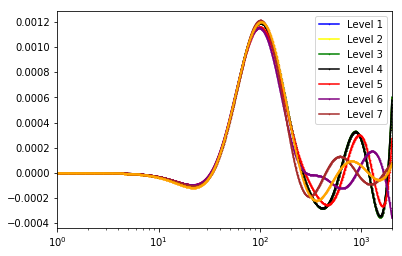

In [40]:
from functools import reduce

fig, ax = plt.subplots()

colors=['blue', 'yellow', 'green', 'black', 'red', 'purple', 'brown', 'grey']

for count in range(1, 8):
    CA = pywt.downcoef('a', exp_lorentz_009, wavelet='db25', level=count)
    approx = pywt.upcoef('a', CA, wavelet='db25', level=count, take=len(exp_lorentz_009))
       
    coeff = simulator.coeff

    # Initial interval
    d_min = 1e-9 # 1 нм
    d_max = 2000e-9

    G_min = coeff/d_max
    G_max = coeff/d_min
    N = 256*8
    M = len(freqs)
    p = (G_max/G_min)**(1/(N-1))
    G = np.zeros(N)

    for j in range(N):
        G[j] = G_min * (p**j)

    A = np.zeros((M,N))

    for i in range(M):
        for j in range(N):
            A[i,j] = G[j] / ((2 * np.pi * freqs[i])**2 + G[j]**2)
            
    clf = sklm.Ridge(alpha = 5e-5)
    clf.fit(A, approx)
    a1 = clf.coef_
    
    ax.plot(1e+9 * coeff/G, a1,'.-', markersize=1, color=colors[count-1], label=f'Level {count}')
    ax.set_xscale('log')
    plt.legend()
    plt.xlim(1, 2000)

clf = sklm.Ridge(alpha = 5e-5)
clf.fit(A, ideal_lorentz)
a2 = clf.coef_

ax.plot(1e+9 * coeff/G, a2,'.-', markersize=1, color='orange', label='Ideal')
plt.xlim(1, 2000)

# Effect of noise (noise_level = 0.05)

(1, 2000)

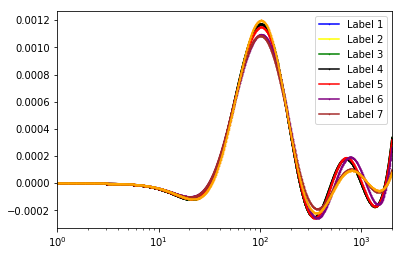

In [41]:
from functools import reduce

fig, ax = plt.subplots()


for count in range(1, 8):
    CA = pywt.downcoef('a', exp_lorentz_005, wavelet='db25', level=count)
    approx = pywt.upcoef('a', CA, wavelet='db25', level=count, take=len(exp_lorentz_005))
       
    coeff = simulator.coeff

    # Initial interval
    d_min = 1e-9 # 1 нм
    d_max = 2000e-9

    G_min = coeff/d_max
    G_max = coeff/d_min
    N = 256*8
    M = len(freqs)
    p = (G_max/G_min)**(1/(N-1))
    G = np.zeros(N)

    for j in range(N):
        G[j] = G_min * (p**j)

    A = np.zeros((M,N))

    for i in range(M):
        for j in range(N):
            A[i,j] = G[j] / ((2 * np.pi * freqs[i])**2 + G[j]**2)
            
    clf = sklm.Ridge(alpha = 5e-5)
    clf.fit(A, approx)
    a1 = clf.coef_

    ax.plot(1e+9 * coeff/G, a1,'.-', markersize=1, color=colors[count-1], label=f'Label {count}')
    ax.set_xscale('log')
    plt.legend()
    plt.xlim(1, 2000)

clf = sklm.Ridge(alpha = 5e-5)
clf.fit(A, ideal_lorentz)
a2 = clf.coef_

ax.plot(1e+9 * coeff/G, a2,'.-', markersize=1, color='orange', label='Ideal')
plt.xlim(1, 2000)

# Effect of noise (noise_level = 0.02)

(1, 2000)

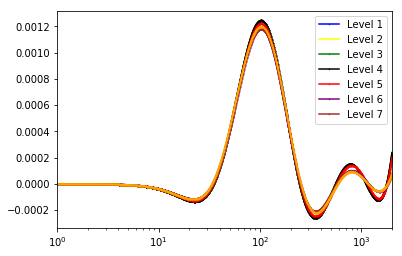

In [42]:
from functools import reduce

fig, ax = plt.subplots()

for count in range(1, 8):
    CA = pywt.downcoef('a', exp_lorentz_002, wavelet='db25', level=count)
    approx = pywt.upcoef('a', CA, wavelet='db25', level=count, take=len(exp_lorentz_002))
    
    coeff = simulator.coeff

    # Initial interval
    d_min = 1e-9
    d_max = 2000e-9

    G_min = coeff/d_max
    G_max = coeff/d_min
    N = 256*8
    M = len(freqs)
    p = (G_max/G_min)**(1/(N-1))
    G = np.zeros(N)

    for j in range(N):
        G[j] = G_min * (p**j)

    A = np.zeros((M,N))

    for i in range(M):
        for j in range(N):
            A[i,j] = G[j] / ((2 * np.pi * freqs[i])**2 + G[j]**2)
            
    clf = sklm.Ridge(alpha = 5e-5)
    clf.fit(A, approx)
    a1 = clf.coef_

    ax.plot(1e+9 * coeff/G, a1,'.-', markersize=1, color=colors[count-1], label=f'Level {count}')
    ax.set_xscale('log')
    plt.legend()
    plt.xlim(1, 2000)

clf = sklm.Ridge(alpha = 5e-5)
clf.fit(A, ideal_lorentz)
a2 = clf.coef_

ax.plot(1e+9 * coeff/G, a2,'.-', markersize=1, color='orange', label='Ideal')
plt.xlim(1, 2000)

# Non-negative Tiknonov regularization

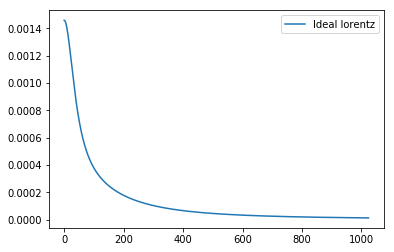

In [52]:
%matplotlib inline

simulator = Simulator()
simulator.configure_experiment()

N_f = 2**12
f_max = 2**10

freqs = np.linspace(0, f_max, N_f)
ideal_lorentz = simulator.get_lorentz(100e-9, freqs) + simulator.get_lorentz(500e-9, freqs) # 100 nm

fig, ax = plt.subplots()
ax.plot(freqs, ideal_lorentz, label='Ideal lorentz')
plt.legend()

In [53]:
#Noise level 0.09
noise_level = 0.09 # main noise level
deviation_noise_level = 0.09 # deviation noise level

deviation_interval_size = 30 # size of each deviation interval
num_deviation_intervals = int(len(ideal_lorentz) / deviation_interval_size) + 1
deviation_noise_levels = np.random.uniform(-deviation_noise_level, deviation_noise_level, num_deviation_intervals)

exp_lorentz_values = []

for i in range(len(ideal_lorentz)):
    value = ideal_lorentz[i]
    
    deviation_interval_index = int(i / deviation_interval_size)
    value *= (1 + deviation_noise_levels[deviation_interval_index])
    
    value *= (1 + np.random.uniform(-noise_level, noise_level))
    
    exp_lorentz_values.append(value)

exp_lorentz = np.array(exp_lorentz_values)

(1, 2000)

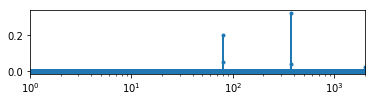

In [54]:
# Non-negative ridge regression
alpha = 1.3e-7
B = np.zeros((M+N, N))
B[0:M,:] = A
B[M::, :] = alpha * np.eye(N)
y_ = np.zeros(M+N)
y_[0:M] = exp_lorentz
a2, rnorm = scipy.optimize.nnls(B,y_)

ax = plt.subplot(3,1,2)
line, = plt.plot(1e+9 * coeff/G, a2,'.-')
ax.set_xscale('log')
plt.xlim(1, 2000)